In [ ]:
# import the necessary packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd
import csv


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_folder = "/content/gdrive/MyDrive/ROB535-Perception-Project-1/"
train_rows = open("{}/task-1-training-dataset-old/train_labels.csv".format(data_folder)).read().strip().split("\n")
train_rows = train_rows[1:]

In [ ]:
train_data = []
train_targets = []
train_filenames = []

In [ ]:
for row in train_rows:
	# break the row into the filename and bounding box coordinates
  row = row.split(",")
  (filename, width, height, class_label, startX, startY, endX, endY) = row
  startX = float(startX) / float(width)
  startY = float(startY) / float(height)
  endX = float(endX) / float(width)
  endY = float(endY) / float(height)
  image = load_img("{}/task-1-training-dataset-old/images/train/{}".format(data_folder,filename), target_size=(224, 224))
  image = img_to_array(image)
  train_data.append(image)
  train_targets.append((startX, startY, endX, endY))
  train_filenames.append(filename)

In [ ]:
valid_rows = open("{}/task-1-training-dataset-old/test_labels.csv".format(data_folder)).read().strip().split("\n")
valid_rows = valid_rows[1:]

In [ ]:
valid_data = []
valid_targets = []
valid_filenames = []

In [ ]:
for row in valid_rows:
	# break the row into the filename and bounding box coordinates
  row = row.split(",")
  (filename, width, height, class_label, startX, startY, endX, endY) = row
  startX = float(startX) / float(width)
  startY = float(startY) / float(height)
  endX = float(endX) / float(width)
  endY = float(endY) / float(height)
  image = load_img("{}/task-1-training-dataset-old/images/test/{}".format(data_folder,filename), target_size=(224, 224))
  image = img_to_array(image)
  valid_data.append(image)
  valid_targets.append((startX, startY, endX, endY))
  valid_filenames.append(filename)

In [ ]:
train_data = np.array(train_data, dtype="float32") / 255.0
train_targets = np.array(train_targets, dtype="float32")

valid_data = np.array(valid_data, dtype="float32") / 255.0
valid_targets = np.array(valid_targets, dtype="float32")

In [ ]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
opt = Adam(lr=1e-4)
model.compile(loss="mse", optimizer=opt)
print(model.summary())
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
	train_data, train_targets,
	validation_data=(valid_data, valid_targets),
	batch_size=32,
	epochs=5,
	verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

[INFO] saving object detector model...


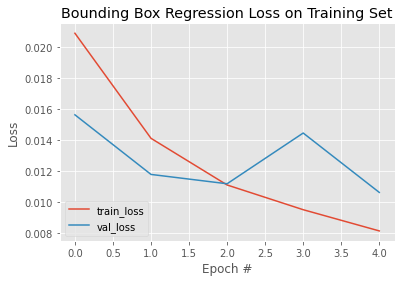

In [ ]:
print("[INFO] saving object detector model...")
model.save("{}/task-1-training-dataset-old/detector.h5".format(data_folder), save_format="h5")
# plot the model training history
N = 5
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("{}/task-1-training-dataset-old/training_history.png".format(data_folder), save_format="h5")

In [ ]:
test_imgs_path = glob('{}test/*/*_image.jpg'.format(data_folder))
test_imgs_path.sort()

In [ ]:
w = 1914
h = 1052
rows = [['filename','width','height','xmin','ymin','xmax','ymax']]
i = 0
for path in test_imgs_path:
  image = load_img(path, target_size=(224, 224))
  image = img_to_array(image) / 255.0
  image = np.expand_dims(image, axis=0)
  preds = model.predict(image)[0]
  (startX, startY, endX, endY) = preds
  startX = int(startX * w)
  startY = int(startY * h)
  endX = int(endX * w)
  endY = int(endY * h)
  p = test_imgs_path[i].split('/')
  path = '{}/{}'.format(p[-2],p[-1])
  rows.append([path,w,h,startX,startY,endX,endY])
  i += 1

In [ ]:
with open ('test_labels.csv','w',newline = '') as csvfile:
    my_writer = csv.writer(csvfile, delimiter = ',')
    my_writer.writerows(rows)